In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency, metrics

import helper
sys.path.append('../..')
import mutagenesisfunctions as mf
np.random.seed(247)
tf.set_random_seed(247)

In [2]:
data_path = '../data/Synthetic_dataset.h5'
results_path = '../results'
params_path = utils.make_directory(results_path, 'model_params')
plot_path = utils.make_directory(results_path, 'FoM_layers')

# load dataset
train, valid, test = helper.load_synthetic_dataset(data_path)

test_model = helper.load_synthetic_models(data_path, dataset='test')
    
# get data shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = [None, train['targets'].shape[1]]

loading training data
loading cross-validation data
loading test data


In [3]:
tf.reset_default_graph()

model_name = 'DistNet'
plot_path = utils.make_directory(plot_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)

activations = nntrainer.get_activations(sess, test, layer='output')

loading model from:  ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt


In [4]:
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 24)
layer3: conv1d_0_batch
(?, 200, 1, 24)
layer4: conv1d_0_active
(?, 200, 1, 24)
layer5: conv1d_0_dropout
(?, 200, 1, 24)
layer6: conv1d_1
(?, 195, 1, 32)
layer7: conv1d_1_batch
(?, 195, 1, 32)
layer8: conv1d_1_active
(?, 195, 1, 32)
layer9: conv1d_1_maxpool
(?, 65, 1, 32)
layer10: conv1d_1_dropout
(?, 65, 1, 32)
layer11: conv1d_2
(?, 60, 1, 48)
layer12: conv1d_2_batch
(?, 60, 1, 48)
layer13: conv1d_2_active
(?, 60, 1, 48)
layer14: conv1d_2_maxpool
(?, 15, 1, 48)
layer15: conv1d_2_dropout
(?, 15, 1, 48)
layer16: conv1d_3
(?, 12, 1, 64)
layer17: conv1d_3_batch
(?, 12, 1, 64)
layer18: conv1d_3_active
(?, 12, 1, 64)
layer19: conv1d_3_maxpool
(?, 4, 1, 64)
layer20: conv1d_3_dropout
(?, 4, 1, 64)
layer21: conv1d_4
(?, 1, 1, 96)
layer22: conv1d_4_batch
(?, 1,

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


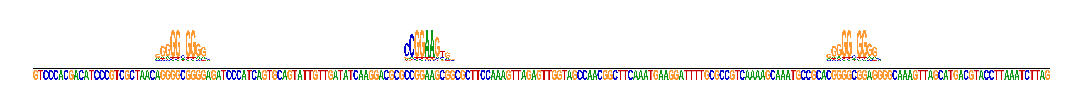

In [5]:
index = 4149
X = np.expand_dims(test['inputs'][index], axis=0)
X_model = test_model[index]


fig = plt.figure(figsize=(15,7))

visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)


output_name = 'modelsequence_' + str(index)
outfile = os.path.join(plot_path, output_name+'.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [6]:
def fom_convsal(X, layer, alphabet, filter_index, max_idx, nntrainer, sess, title='notitle', figsize=(15,2)
                , fig=None, pos=None, idx=None):
    
    eps = 1e-7
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get the neurons score for the mutations
    mut_scores = nntrainer.get_activations(sess, mutations, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get activations for the WT sequence
    WT_score = nntrainer.get_activations(sess, WT, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_scores.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    #norm_heat_mut = (heat_mut - WT_score) + eps
    #norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    return (heat_mut)

# DistNet

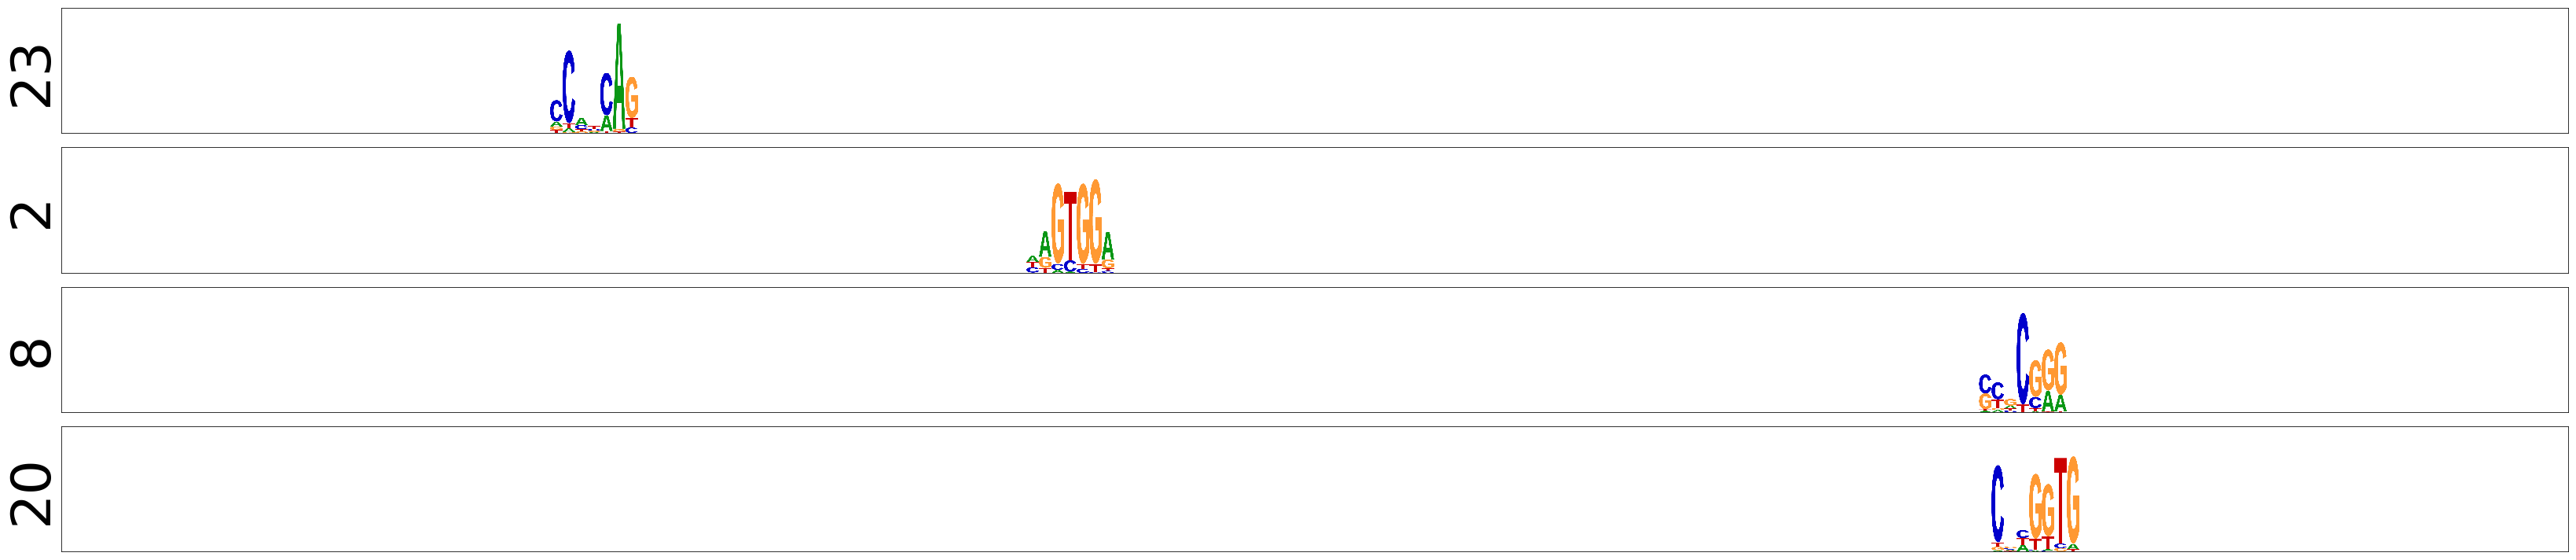

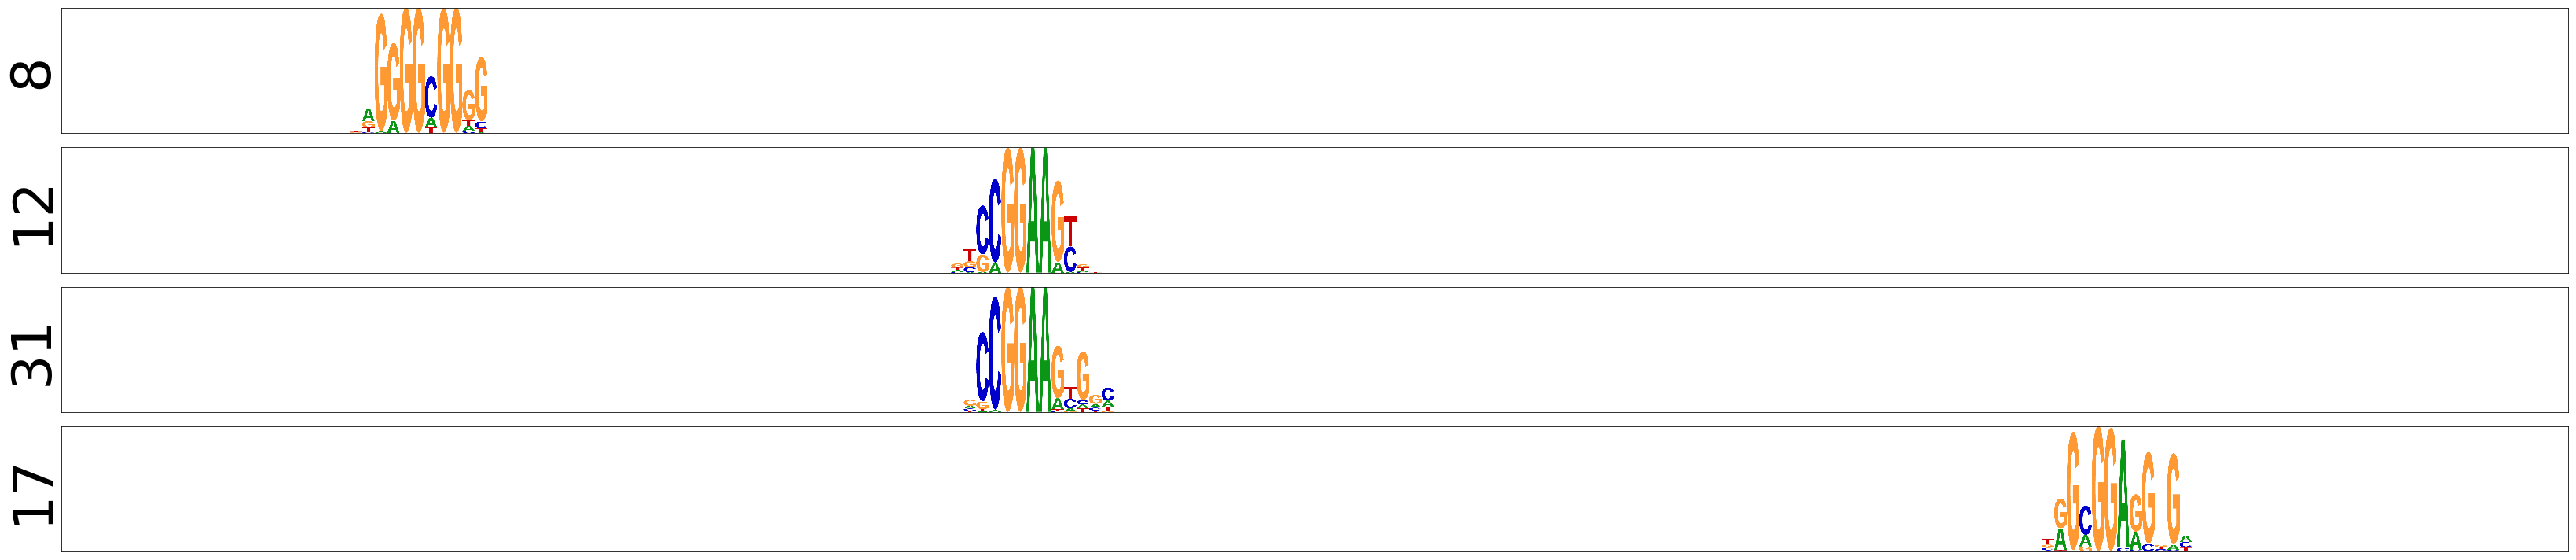

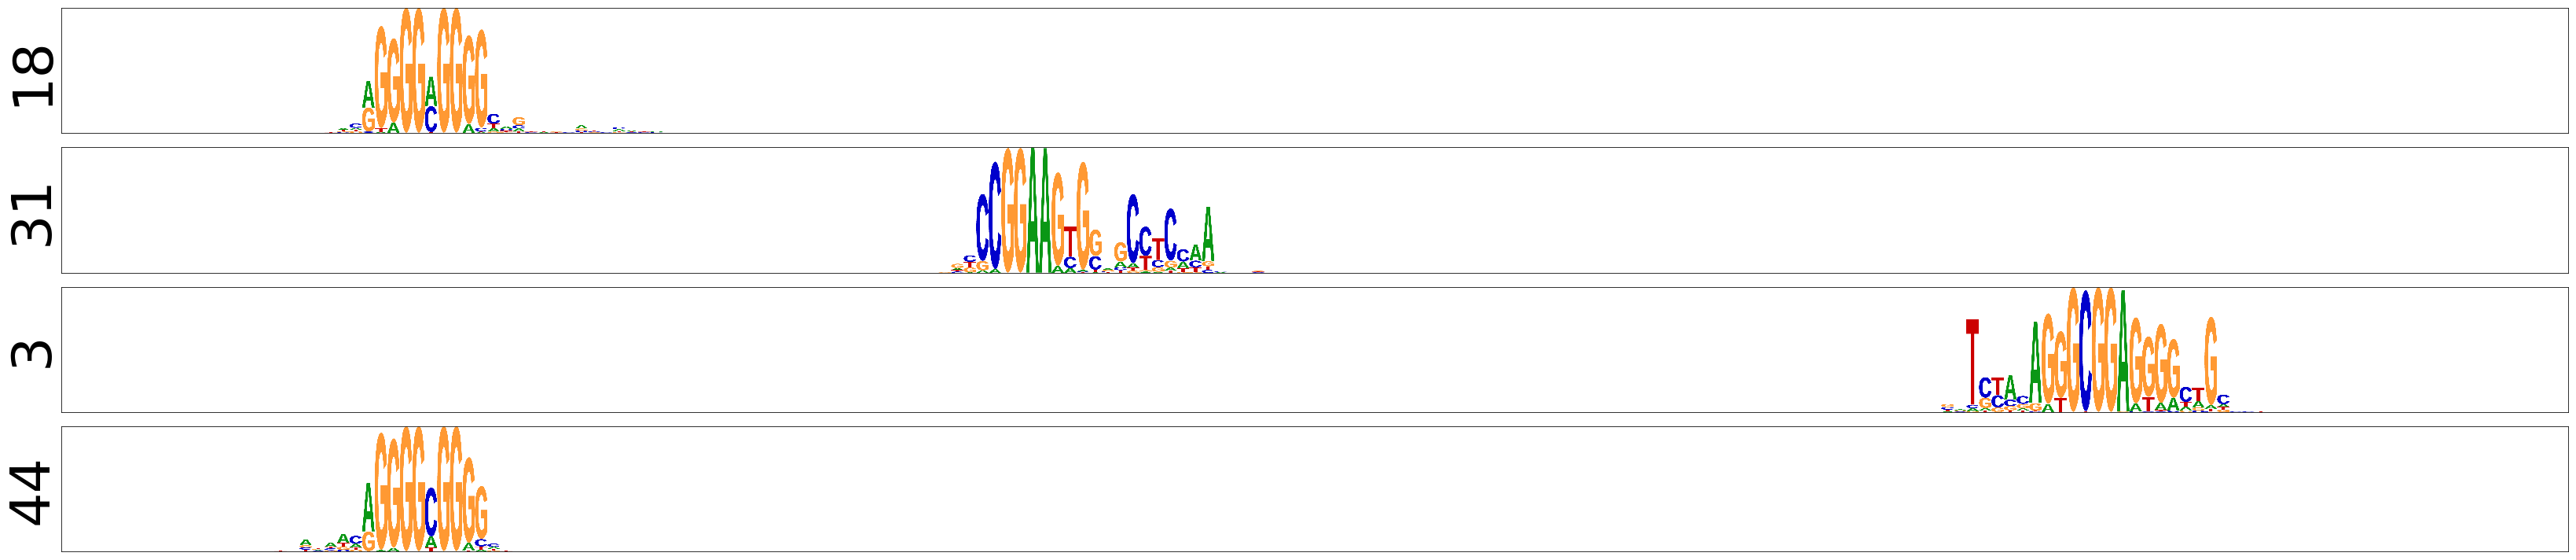

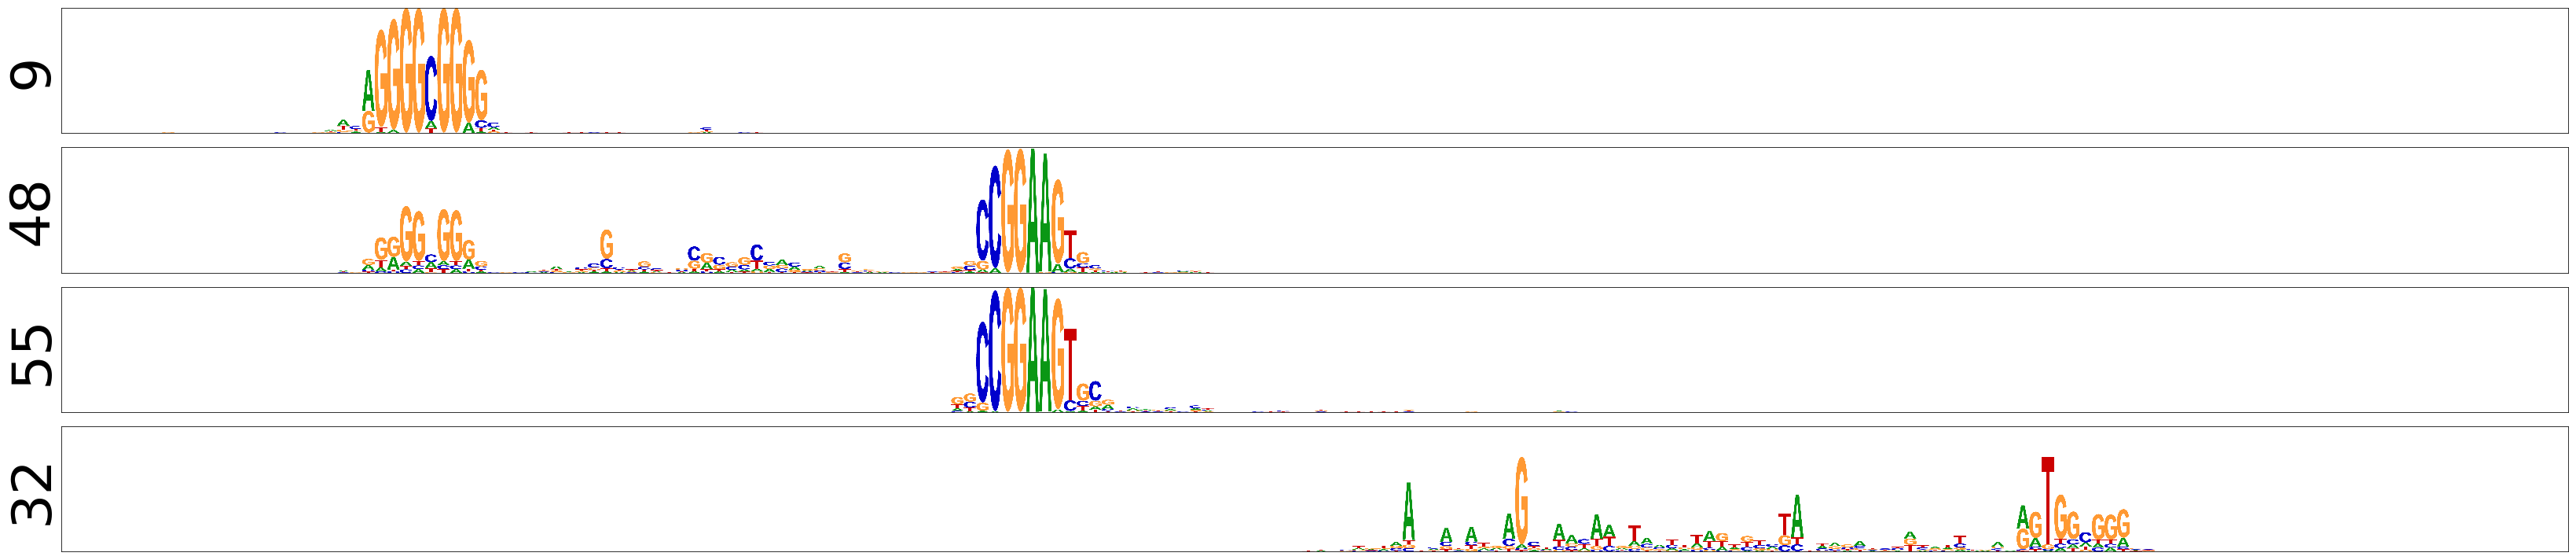

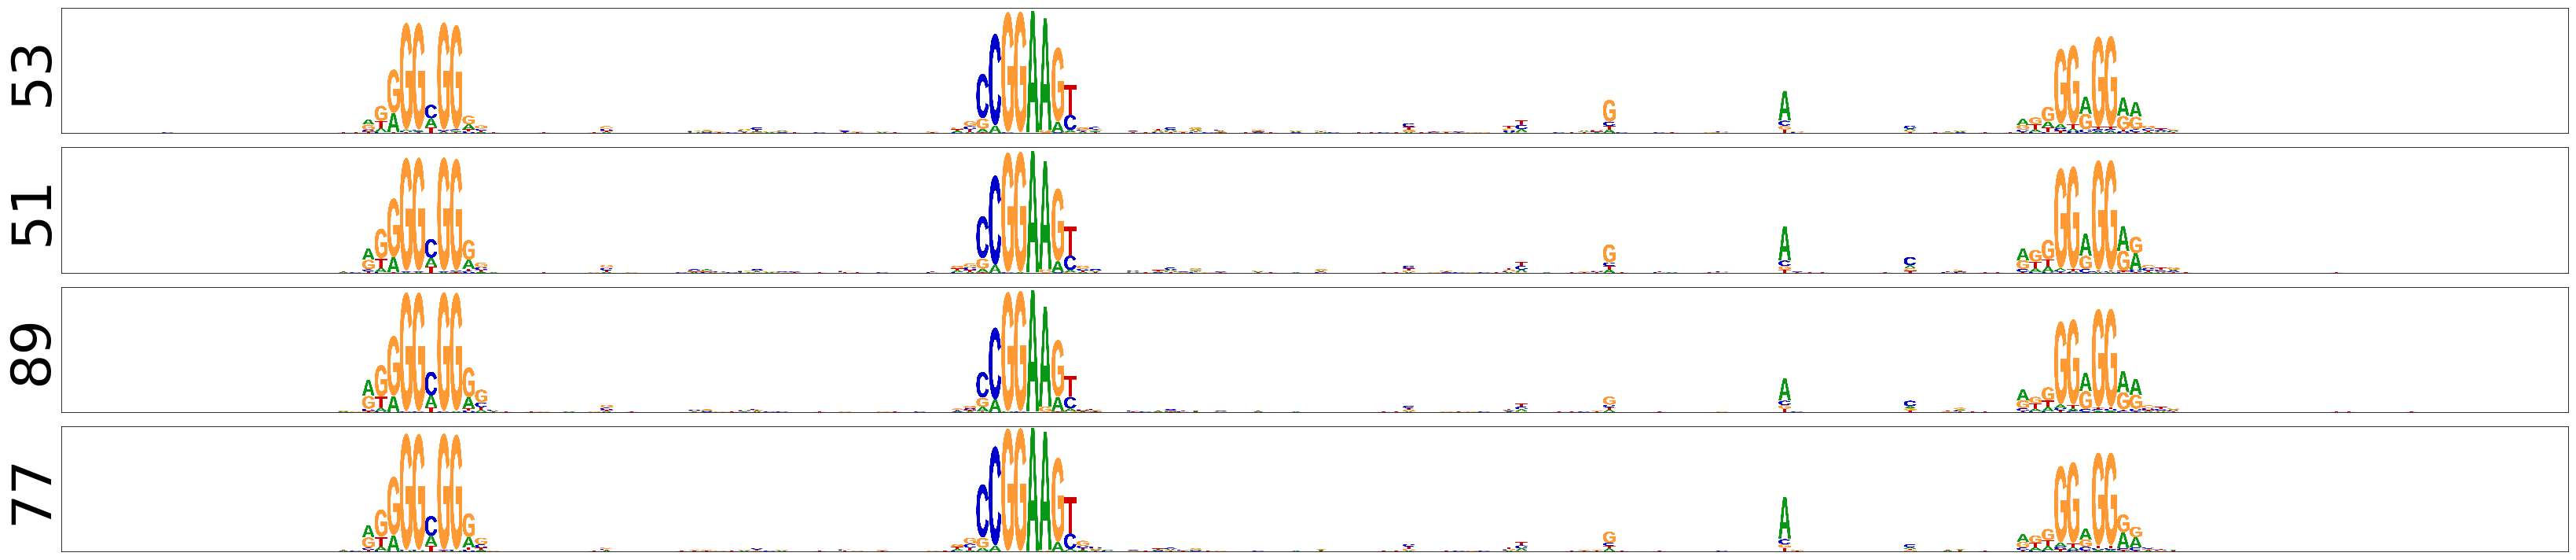

In [7]:
neuron_plot = [['conv1d_0_active', [23,2,8,20]],
                 ['conv1d_1_active', [8,12,31,17]],
                 ['conv1d_2_active', [18,31,3,44]],
                 ['conv1d_3_active', [9,48,55,32]],
                 ['conv1d_4_active', [53,51,89,77]]]

for layer, active_indices in neuron_plot:

    layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)

    #For each filter what is the index of the maximally activated neuron
    max_idx = np.squeeze(np.argmax(layer_act, axis=1))

    #Identify the desired filter
    filters = active_indices

    fom_scores = []
    for filter_index in filters:
    #Get the FoM scores for each desired filter
        fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

    num_plots = len(filters)


    fig = plt.figure(figsize=(100,10))
    plt.title(str(layer), fontsize=70)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(fom_scores[0], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(fom_scores[1], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(fom_scores[2], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(fom_scores[3], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[3]), fontsize=70)

# LocalNet

loading model from:  ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt


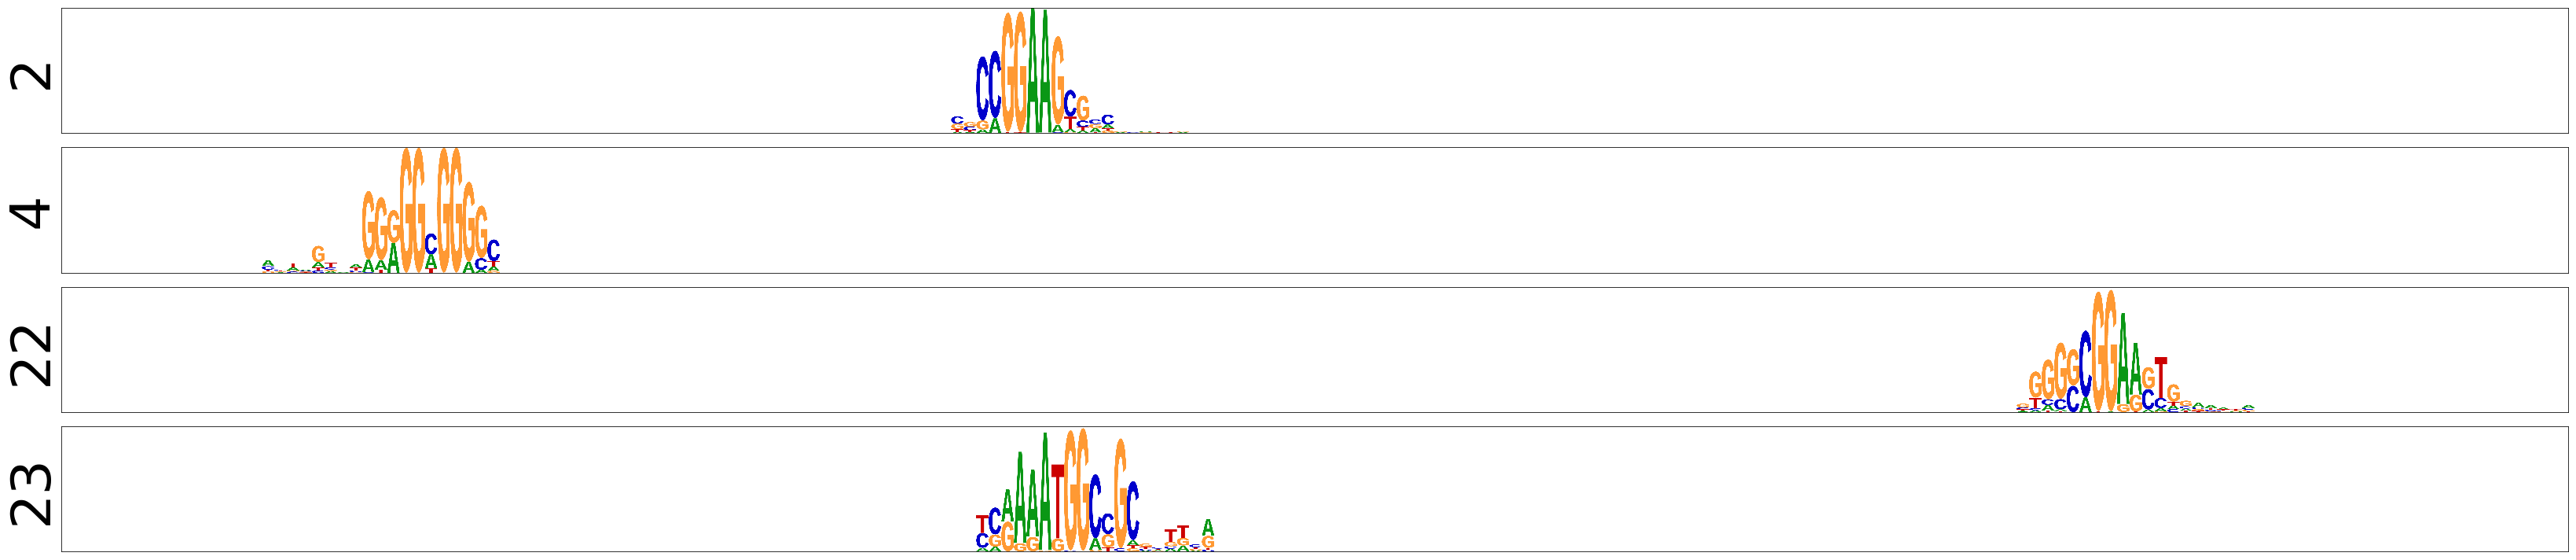

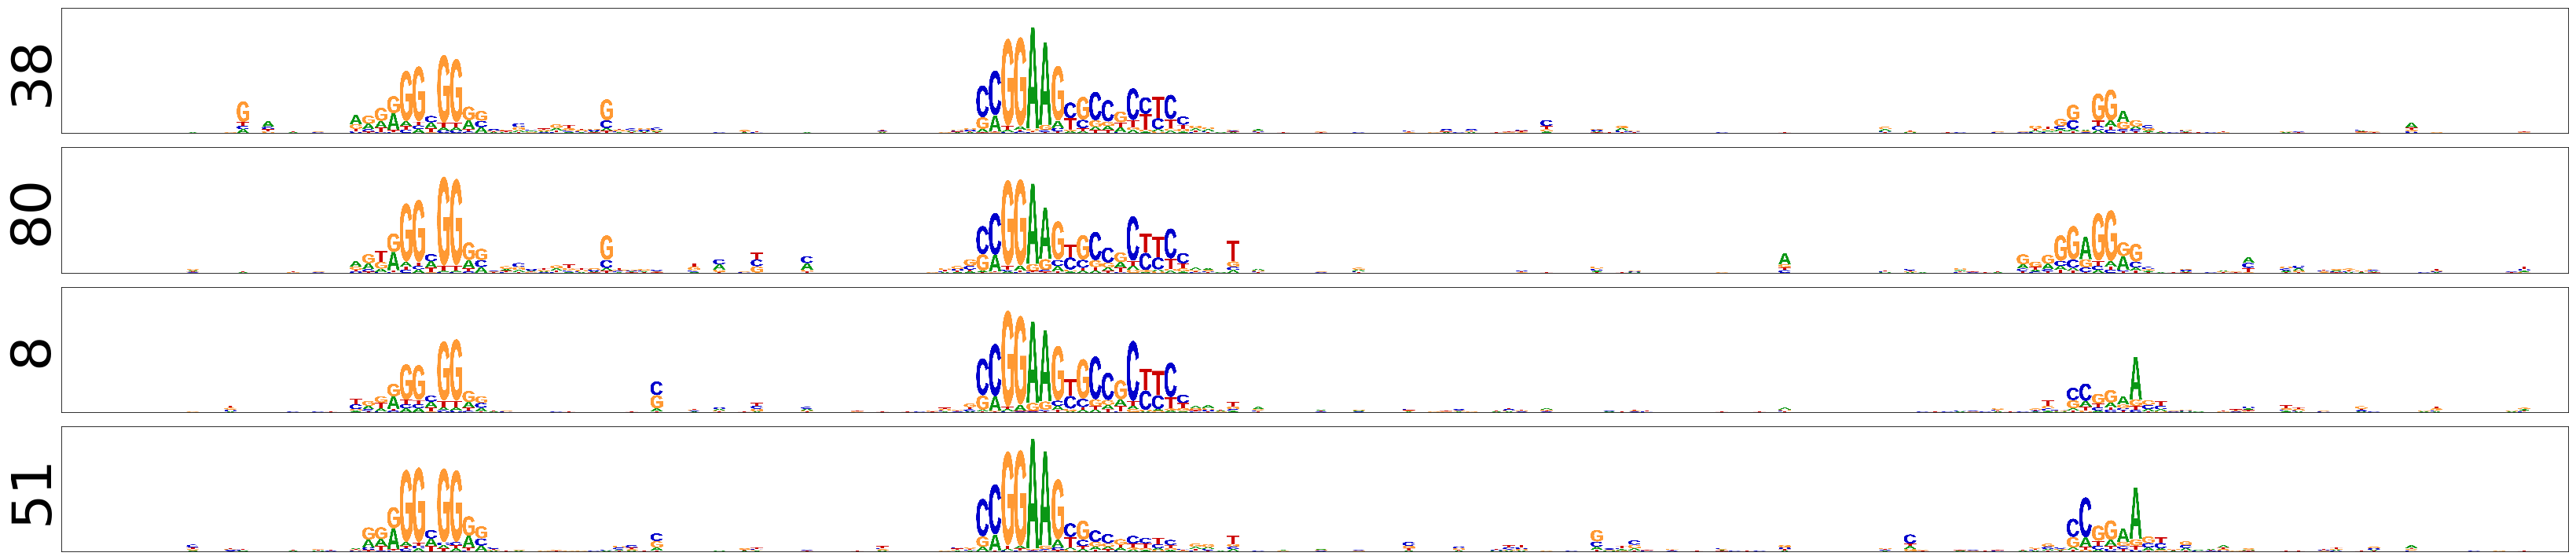

In [8]:
tf.reset_default_graph()

model_name = 'LocalNet'
plot_path = utils.make_directory(plot_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)


neuron_plot = [['conv1d_0_active', [2,4,22,23]],
                 ['conv1d_1_active', [38,80,8,51]]]

for layer, active_indices in neuron_plot:

    layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)

    #For each filter what is the index of the maximally activated neuron
    max_idx = np.squeeze(np.argmax(layer_act, axis=1))

    #Identify the desired filter
    filters = active_indices

    fom_scores = []
    for filter_index in filters:
    #Get the FoM scores for each desired filter
        fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

    num_plots = len(filters)


    fig = plt.figure(figsize=(100,10))
    plt.title(str(layer), fontsize=70)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(fom_scores[0], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(fom_scores[1], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(fom_scores[2], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(fom_scores[3], factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[3]), fontsize=70)